## Spacenet

https://medium.com/the-downlinq/establishing-a-machine-learning-workflow-530628cfe67

https://medium.com/the-downlinq/object-detection-on-spacenet-5e691961d257

https://medium.com/the-downlinq/the-spacenet-metric-612183cc2ddb

https://medium.com/the-downlinq/a-baseline-model-for-the-spacenet-4-off-nadir-building-detection-challenge-6b7983312b4b

https://medium.com/the-downlinq

Fastai lesson 3

https://github.com/hiromis/notes/blob/master/Lesson3.md


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime
import uuid

In [3]:
import PIL.Image as pil_image

In [4]:
from fastai import *
from fastai.vision import *

In [5]:
from fastai.utils import *
import fastai
print(fastai.__version__)

1.0.36.dev0


In [6]:
torch.cuda.set_device(0)

In [7]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
print(f'DATE: {DATE}') 

DATE: 20181209


In [8]:
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}') 

UID: af27e193


In [9]:
ARCH = models.resnet34
ARCH_NAME = 'rn34'
MODEL_NAME = 'unet'

## Load Data

In [10]:
path = Path('../../ssd_data/SpaceNet_Off-Nadir_Dataset')
path.ls()

[PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks'),
 PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_test')]

In [11]:
path_img = path/'resized_train'
path_lbl = path/'resized_masks'
path_test = path/'resized_test'

In [12]:
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)
fnames[:3], lbl_names[:3] 

([PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir8_catid_10300100023BC100_743051_3741339.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir50_catid_10300100039E6200_743951_3724689.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir19_catid_1030010003C92000_739901_3727839.png')],
 [PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_739901_3739539.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_744851_3734139.png'),
  PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_739901_3735939.png')])

In [13]:
len(fnames), len(lbl_names)

(28728, 1064)

In [14]:
def get_y_fn(full_name):
    parts = str(full_name).split('_')
    im_id = '_'.join(parts[-2:])
    mask_name = 'mask_'+im_id
    return path_lbl/f'{mask_name}'

In [15]:
#problem image/mask match:

#739001_3724239

In [16]:
img_f = fnames[-1]
img = open_image(img_f)
mask_f = get_y_fn(img_f)
mask = open_mask(mask_f, div=True)
print(f'img: {img_f}, mask: {mask_f}')


img: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir13_catid_1030010002B7D800_739001_3724239.png, mask: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_masks/mask_739001_3724239.png


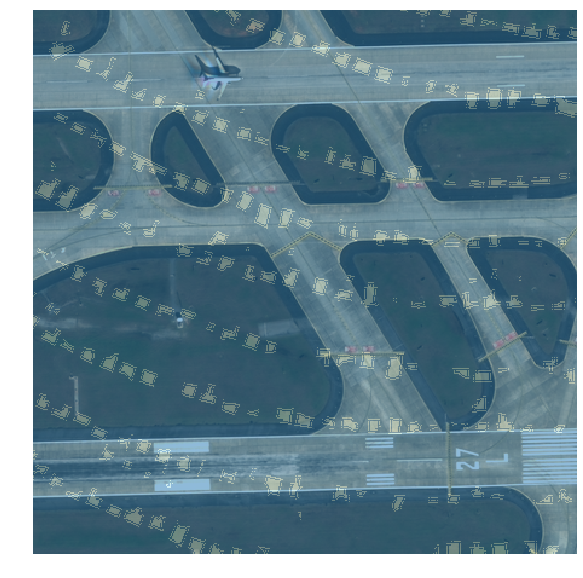

In [17]:
fig,ax = plt.subplots(1,1, figsize=(10,10))
img.show(ax=ax)
mask.show(ax=ax, alpha=0.5)

In [18]:
src_size = np.array(mask.shape[1:])
print(src_size)
mask.data

[450 450]


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

# Make DataBunch

In [19]:
size = src_size
bs=4

In [20]:
holdout_grids = ['735851','747551','741251','746201']
valid_idx = [i for i,o in enumerate(fnames) if any(c in str(o) for c in holdout_grids)]

In [21]:
codes = np.array(['nadir','offnadir','faroffnadir'])

In [22]:
# subclassing SegmentationLabelList to set open_mask(fn, div=True), probably a better way to do this?
# idea from https://forums.fast.ai/t/unet-binary-segmentation/29833/40

class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegItemListCustom(ImageItemList):
    _label_cls = SegLabelListCustom

In [23]:
src = (SegItemListCustom.from_folder(path_img)
        #.split_by_idx(valid_idx)
        .random_split_by_pct(0.2)
        .label_from_func(get_y_fn, classes=codes))

In [24]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_zoom=1.2, max_lighting=0.3)
data = (src.transform(tfms, size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [25]:
data

ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (22983 items)
[ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train
x: SegItemListCustom (22983 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train;

Valid: LabelList
y: SegLabelListCustom (5745 items)
[ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train
x: SegItemListCustom (5745 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train;

Test: None

In [26]:
data.valid_ds.items

array([PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir34_catid_1030010003697400_746201_3741789.png'),
       PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir21_catid_1030010003127500_734051_3726489.png'),
       PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir25_catid_103001000307D800_733151_3735489.png'),
       PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir10_catid_1030010003CAF100_740351_3739539.png'),
       ...,
       PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir7_catid_1030010003D22F00_746651_3742689.png'),
       PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir42_catid_10300100035D1B00_737651_3733689.png'),
       PosixPath('../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train/Pan-Sharpen_Atlanta_nadir21_catid

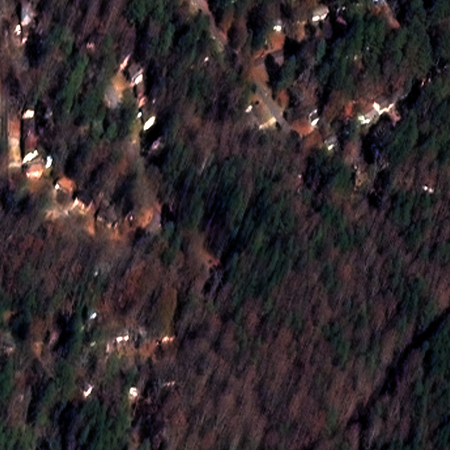

In [27]:
data.train_ds.x[1]

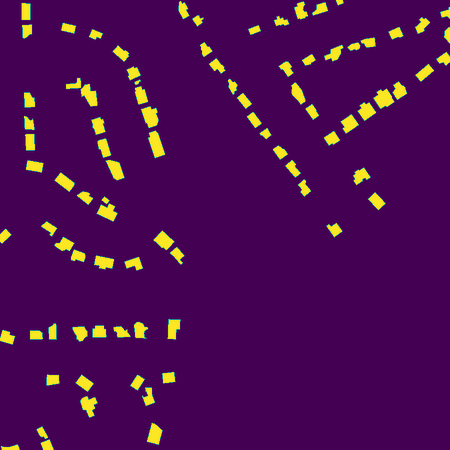

In [28]:
data.train_ds.y[1]

In [29]:
data.train_ds.y[1].data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 1,  ..., 0, 0, 0]]])

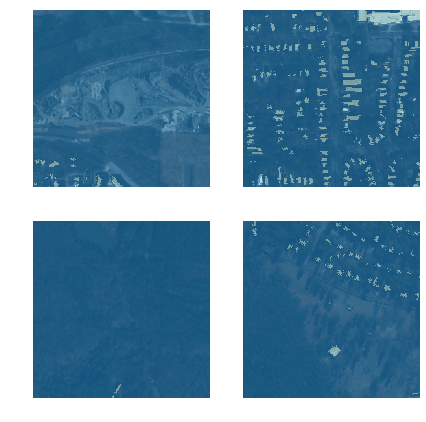

In [30]:
data.show_batch(2,figsize=(6,6), alpha=0.7)

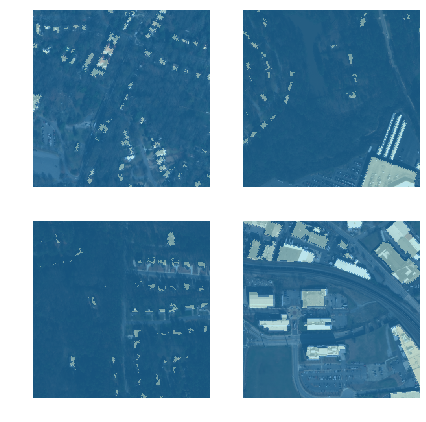

In [31]:
data.show_batch(2,figsize=(6,6), ds_type=DatasetType.Valid, alpha=0.7)

In [32]:
data.classes

array(['nadir', 'offnadir', 'faroffnadir'], dtype='<U11')

In [33]:
#### export for later use

In [34]:
data.export

<bound method DataBunch.export of ImageDataBunch;

Train: LabelList
y: SegLabelListCustom (22983 items)
[ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train
x: SegItemListCustom (22983 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train;

Valid: LabelList
y: SegLabelListCustom (5745 items)
[ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450), ImageSegment (1, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train
x: SegItemListCustom (5745 items)
[Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450), Image (3, 450, 450)]...
Path: ../../ssd_data/SpaceNet_Off-Nadir_Dataset/resized_train;

Test: None>

# Custom Loss

In [35]:
import pdb

In [36]:
def dice_loss(input, target):
#     pdb.set_trace()
    smooth = 1.
    input = input[:,1,None].sigmoid()
    iflat = input.contiguous().view(-1).float()
    tflat = target.view(-1).float()
    intersection = (iflat * tflat).sum()
    return (1 - ((2. * intersection + smooth) / ((iflat + tflat).sum() +smooth)))

def combo_loss(pred, targ):
    bce_loss = CrossEntropyFlat(axis=1)
    return bce_loss(pred,targ) + dice_loss(pred,targ)

## Define Model

In [37]:
def acc_fixed(input, targs):
    n = targs.shape[0]
    targs = targs.squeeze(1)
    targs = targs.view(n,-1)
    input = input.argmax(dim=1).view(n,-1)
    return (input==targs).float().mean()

def acc_thresh(input:Tensor, target:Tensor, thresh:float=0.5, sigmoid:bool=True)->Rank0Tensor:
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    
#     pdb.set_trace()
    if sigmoid: input = input.sigmoid()
    n = input.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    target = target.view(n,-1)
    return ((input>thresh)==target.byte()).float().mean()

In [38]:
# iou = partial(dice, iou=True)
metrics = [dice_loss, acc_thresh, dice]

In [39]:
learn = unet_learner(data, models.resnet34, metrics=metrics)

In [40]:
learn.loss_func

In [41]:
learn.loss_func = combo_loss
learn.loss_func

<function __main__.combo_loss(pred, targ)>

In [42]:
# learn.opt_func = partial(optim.SGD,momentum=0.9)

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


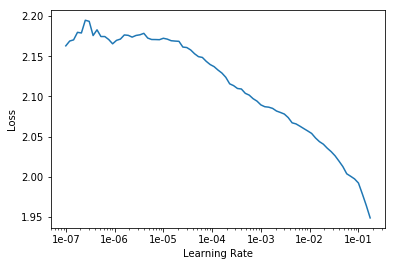

In [44]:
learn.recorder.plot(0,0)

In [45]:
lr = 2e-2

In [46]:
from fastai.callbacks import *

# small change to SaveModelCallback() to add printouts
@dataclass
class SaveModelCallbackVerbose(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    every:str='improvement'
    name:str='bestmodel'
    def __post_init__(self):
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                self.best = current
                self.learn.save(f'{self.name}')
                print(f'saved model at epoch {epoch} with {self.monitor} value: {current}')

    def on_train_end(self, **kwargs):
        if self.every=="improvement": self.learn.load(f'{self.name}')

In [47]:
learn.fit_one_cycle(10, max_lr=lr, 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name=f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-best-{UID}')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.708135,0.657335,0.496365,0.942074,0.268209
2,0.668039,0.652064,0.484622,0.941806,0.252956
3,0.661702,0.621154,0.466579,0.942586,0.287592
4,0.659605,0.612019,0.464093,0.947846,0.478879
5,0.664022,0.617040,0.470968,0.947579,0.455351
6,0.668268,0.585312,0.443270,0.950616,0.513999
7,0.787490,0.768248,0.584479,0.933160,0.238136
8,0.772967,0.727661,0.555729,0.938651,0.284044
9,0.749411,0.722786,0.551444,0.939398,0.258020
10,0.770218,0.737579,0.563298,0.938701,0.343095


saved model at epoch 1 with dice value: 0.2682085335254669
saved model at epoch 3 with dice value: 0.2875922918319702
saved model at epoch 4 with dice value: 0.4788787066936493
saved model at epoch 6 with dice value: 0.5139994025230408


In [48]:
learn.load(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-best-{UID}')
learn.model.eval()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [49]:
outputs = learn.pred_batch(ds_type=DatasetType.Valid)

In [50]:
outputs.shape

torch.Size([4, 3, 450, 450])

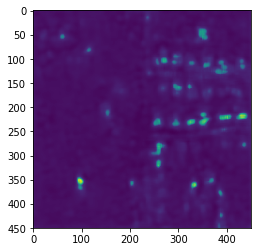

In [51]:
plt.imshow((to_np(outputs[2][1])))

In [52]:
outputs[2][1].sigmoid()

tensor([[0.0008, 0.0007, 0.0007,  ..., 0.0012, 0.0014, 0.0019],
        [0.0007, 0.0007, 0.0007,  ..., 0.0013, 0.0015, 0.0020],
        [0.0006, 0.0006, 0.0006,  ..., 0.0008, 0.0010, 0.0013],
        ...,
        [0.0012, 0.0015, 0.0012,  ..., 0.0014, 0.0014, 0.0016],
        [0.0012, 0.0015, 0.0011,  ..., 0.0013, 0.0014, 0.0016],
        [0.0014, 0.0016, 0.0012,  ..., 0.0012, 0.0014, 0.0017]])

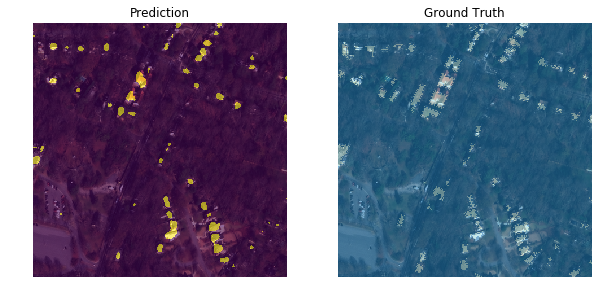

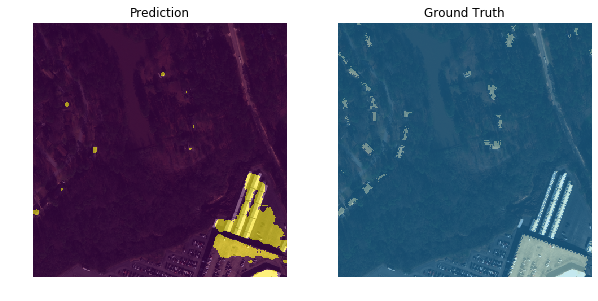

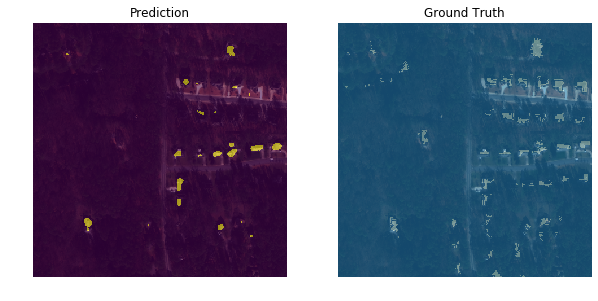

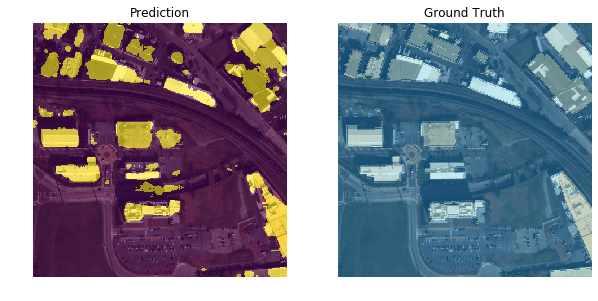

In [53]:
for i in range(bs):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[i][1].sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

## Unfreeze and Train More

In [54]:
learn.model.train()

DynamicUnet(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [55]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


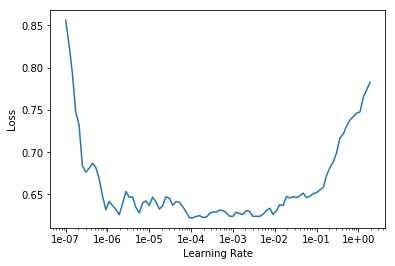

In [56]:
learn.recorder.plot(0,0)

In [59]:
lr = 1e-3

In [60]:
learn.fit_one_cycle(30, max_lr=slice(1e-6,lr/10), 
                    callbacks=[
                        SaveModelCallbackVerbose(learn,
                                                 monitor='dice',
                                                 mode='max',
                                                 name=f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-best-{UID}')
                    ]
                   )

epoch,train_loss,valid_loss,dice_loss,acc_thresh,dice
1,0.561842,0.535211,0.406143,0.954221,0.518703
2,0.583111,0.533832,0.405895,0.954537,0.548782
3,0.591623,0.534535,0.406217,0.954556,0.534148
4,0.593995,0.531323,0.403641,0.954582,0.560322
5,0.599572,0.533967,0.405592,0.954570,0.538210
6,0.569827,0.531552,0.403863,0.954613,0.551218
7,0.585938,0.532063,0.404094,0.954515,0.522321
8,0.595431,0.537381,0.408446,0.954237,0.552758
9,0.541381,0.527855,0.400799,0.954946,0.548473
10,0.575448,0.531906,0.403995,0.954615,0.553199


saved model at epoch 1 with dice value: 0.5187033414840698
saved model at epoch 2 with dice value: 0.548782229423523
saved model at epoch 4 with dice value: 0.5603216290473938
saved model at epoch 12 with dice value: 0.5706065893173218
saved model at epoch 16 with dice value: 0.5786494612693787


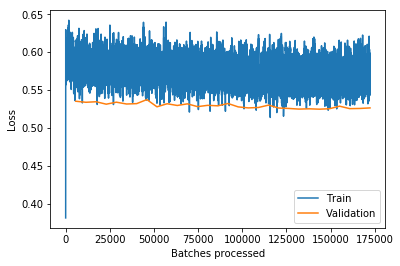

In [61]:
learn.recorder.plot_losses()

In [63]:
#save model after these n epochs
learn.save(f'{DATE}-{ARCH_NAME}-{MODEL_NAME}-comboloss-unfreeze-30-epochs-{UID}')
        

In [62]:
outputs = learn.get_preds(ds_type=DatasetType.Valid)

RuntimeError: CUDA out of memory. Tried to allocate 296.75 MiB (GPU 0; 10.91 GiB total capacity; 7.47 GiB already allocated; 135.69 MiB free; 1.75 GiB cached)

In [ ]:
outputs[0][0][1].squeeze(0).shape

In [ ]:
plt.imshow((to_np(outputs[0][0][1].squeeze(0))))

In [ ]:
outputs[0][0][1].squeeze(0).sigmoid()

In [ ]:
for i in range(bs*2):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[0][i][1].squeeze(0).sigmoid())>0.95), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()

In [ ]:
for i in range(bs*2):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

    data.valid_ds.x[i].show(ax=ax1)
    ax1.set_title('Prediction')
    ax1.imshow((to_np(outputs[0][i][1].squeeze(0).sigmoid())), alpha=0.6)
    
    ax2.set_title('Ground Truth')
    data.valid_ds.x[i].show(ax=ax2)
    data.valid_ds.y[i].show(ax=ax2, alpha=0.6)
    plt.show()